# Ch `08`: Concept `01`

## Reinforcement learning

The **states** are previous history of stock prices, current budget, and current number of shares of a stock.

The **actions** are buy, sell, or hold (i.e. do nothing).

The stock market data comes from the Yahoo Finance library, `pip install yahoo-finance`.

In [1]:
%matplotlib inline
from yahoo_finance import Share
from matplotlib import pyplot as plt
import numpy as np
import random
import tensorflow as tf
import random

Define an abstract class called `DecisionPolicy`:

In [2]:
#Clase padre que implementa una politica
#No tiene construcctor, y es esencialmente virtual
class DecisionPolicy:
    #Implementa la politica para seleccionar una accion en funcion del estado
    def select_action(self, current_state, step):
        #Es el equivalente a virtual en C
        pass

    def update_q(self, state, action, reward, next_state):
        #Es el equivalente a virtual en C
        pass

Here's one way we could implement the decision policy, called a random decision policy:

In [3]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        #Crea una propiedad actions donde se guardaran las acciones posibles
        self.actions = actions

    #Elige una accion al azar
    def select_action(self, current_state, step):
        action = random.choice(self.actions)
        return action

That's a good baseline. Now let's use a smarter approach using a neural network:

In [4]:
#Q es la utilidad
#Determina cual es el valor a largo plazo
#Q = Q + epsilon * (-Q + reward + gamma * maxQ')
#si gamma es 0 lo que estamos diciendo es que la utilidad es la recompensa que obtenemos en un determinado
#instante. Cuando mayor sea gamma, mas valor damos a mazimizar no la recopensa en un determinado momento, sino el valor a 
#largo plazo
#
#La red tiene como entrada el estado, y como salida la utilidad q que logramos con cada accion que tomamos
#esto es, usando esta funcion no estamos basando la eleccion de una accion EN LA RECOMPENSA INMEDIATA, SINO EN 
#AQUELLO QUE AUMENTE Q, LA UTILIDAD, MÁS. El parametro gamma define cuan equivalente recompensa y q son
class QLearningDecisionPolicy(DecisionPolicy):
    #Constructor
    def __init__(self, actions, input_dim):
        #Q = reward + gamma * maxQ'
        self.gamma = 0.3

        #Epsilon es un valor que cuanto mas cercano a uno sea, mas probable se hace que se elija la accion en base
        #a lo que diga nuestra RN. Si el valor es 1, siempre se usa la RN. Si .95, el 5% de las ocasiones eligiremos
        #la accion al azar
        self.epsilon = 0.95
        
        #Guarda las acciones posibles
        self.actions = actions
        
        #Vamos a definir una red neuronal. La RN modelara la utilidad Q.
        #Dado un estado, nos dira cual es la utilidad que podemos esperar para cada una de las acciones posibles
        
        #La red neuronal tendra como salida un vector con el valor de la funcion q para cada una de 
        #las acciones posibles. Esto es, con un estado de partida, la RN
        #nos dira en cada salida cual es el valor de q tras tomar una determinada accion
        output_dim = len(actions)
        
        #Salida desperada de la red neuronal. Q para cada accion
        self.y = tf.placeholder(tf.float32, [output_dim])
        
        #Entrada a la red neuronal. Sera el vector que representa el estado
        self.x = tf.placeholder(tf.float32, [None, input_dim])

        #Capas intermedias - hidden
        h1_dim = 20
        #Parametros que podran aprenderse en la primera capa intermedia
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        #Salida de la primera capa intermedia. Usa una activacion relu
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        
        #Parametros que podran aprenderse en la segunda capa intermedia
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        
        #Salida de la red neuronal. Usa una activacion relu
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        #La funcion de error cuadratica
        loss = tf.square(self.y - self.q)
        
        #Aprendizaje. Crea una propiedad en la que guardara el modelo de aprendizaje
        self.train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
        
        #Session. Ademas las variables de la sesion se han inicializado
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    #Define la policy
    #La policy determina dado un estado, que accion debe tomarse
    #
    #     s -> a
    #
    #Se usa el parametro epsilon
    #Step indica el paso que estamos simulando. Viene a ser el instante de tiempo
    def select_action(self, current_state, step):
        #EL threshold ira aumentando con cada paso, de modo que cuanto mayor sea el paso mas probable sera elegir
        #la accion con la red neuronal. Al principio es mas probable que elijamos la accion al azar
        threshold = min(self.epsilon, step / 1000.)
        #Con este truco tratamos de paliar el overfitting
        if random.random() < threshold:
            #El criterio es simple, usar la accion que maximice la utilidad Q
            #Utiliza la red neuronal para determinar la utilidad de cada accion
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            #Elegimos la accion que de lugar a una utilidad, Q, maxima
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            #
            #Elige una accion al azar
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    #En este metodo lo que vamos a hacer es entrenar la RN. Este es el corazon del Reinforce Learning
    #Hay un aprendizaje que no esta basado en un training data, pero en nuestra experiencia, lo que percibimos
    #Lo que queremos es aprender a calcular la utilidad que podemos conseguir con una determinada accion 
    #cuando nuestro estado es uno dado
    #PAra entrenar a la RN necesitamos definir un valor esperado. Lo definimos usando una funcion que "entendemos"
    #modela la utilidad de forma correcta. En nuestro caso:
    #Q = reward + gamma * maxQ'
    #En un juego de ajedrez, por ejemplo, esta funcion modelaria cual es el valor de nuestra partida cuando tomamos
    #una determinada accion. Necesitariamos 
    #1. Saber el valor en cada momento la posicion del tablero. En nuestro ejercio la posicion de nuestro tablero es
    # el valor del portfolio, calculado como el budget -cash - mas el valor de las acciones que tenemos
    #2. En cada simulacion lo que hariamos es ir haciendo en cada instante un movimiento, evaluar la posicion del tablero, 
    #entrenar la red, evaluar el siguiente movimiento, y asi hasta terminar la partida. Una simulacion seria una partida
    #En nuestro ejemplo, en cada partida evaluamos como evolucionario nuestro portfolio cada dia si fueramos tomando 
    #determinadas acciones. Al final de la simulacion habriamos llegado al ultimo dia del periodo 
    #
    # s + a -> q
    #
    def update_q(self, state, action, reward, next_state):
        
        #Dado el estado actual, utiliza la RN para obtener la Q que la red predice para cada accion
        #No estamos entrenando la RN, estamos usando el kernel y bias actual para calcular la acción
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        
        #1. Calcula maxQ
        #hace lo mismo que antes, pero usando el siguiente estado
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        #Determina cual seria el valor maximo de Q en el siguiente estado
        next_action_idx = np.argmax(next_action_q_vals)
        
        #Obtiene cual es la accion que acabamos de usar (entrada a esta funcion)
        current_action_idx = self.actions.index(action)
        
        #2. Calcula cual sera el nuevo Q para (s,a,r,s') segun la formula Q = reward + gamma * maxQ'
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))

        #3. Entrena la RN con el estado y el valor calculado de Q
        #De esta forma, la RN aprende a calcular el valor de la Q definida como Q = reward + gamma * maxQ'
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})

Define a function to run a simulation of buying and selling stocks from a market:

In [5]:
#Devuelve el valor total de nuestro portfolio. Esto es, la suma del cash mas el valor de las acciones
# initial_budget, initial_num_stocks
#el cash inicial, y el numero de acciones iniciales
# prices
# La evolucion del precio de la accion a lo largo del tiempo
# hist
# A la hora de tomar decisiones con nuestra politica, utilizaremos el precio de la accion en el pasado. hist
#define cuantos periodos atras nos remontaremos. 1 significaria que tomamos decisiones con la politica usando
#el precio de la accion en el dia anterior. 2, significaria que usamos el precio en los dos dias antereiores
#
#En la primera ejecucion de la simulacion, y en el primer paso, la politica determinara la accion usando unos pesos
#que no se han entrenado en absoluto
#A medida que ejecutamos simulaciones vamos entrenando esta RN, con lo que deberiamos ver que el valor de nuestro portofolio
#deberia incrementarse
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    #El estado es una lista formada por hist precios de la accion, el presupuesto y el numero de acciones
    #Presupuesto al inicio
    budget = initial_budget
    #Numero de acciones al inicio
    num_stocks = initial_num_stocks
    #precio de la accion al inicio
    share_value = 0
    
    transitions = list()
    #para cada uno de los instantes para los que tenemos precios, 
    #1. determinara el estado
    #2. y con el estado cual es la accion a tomar
    #3. Con la accion determina cual es la reward y el siguiente estado
    #
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        
        #1. Determina cual es el estado actual. 
        #Sera un vector de hist + 2 dimensiones. 
        #Las dos ultimas dimensiones son el cash y el numero de acciones
        #las primeras hist posiciones son el precio de la accion en los instantes x a x+hist
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        
        #El portfolio se define como el valor monetario: cash mas el valor de las acciones
        #El reward de una determinada accion se define como el cambio de valor del portfolio
        current_portfolio = budget + num_stocks * share_value
        
        #2. Con el estado, seleccionamos la accion
        action = policy.select_action(current_state, i)
        
        #3. Calculamos el reward
        share_value = float(prices[i + hist])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        
        #3. y calculamos el siguiente estado. Notese que los precios de la accion corresponden a un instante mas tarde
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        
        #Guardamos en la lista de transicciones el: estado actual, la accion que hemos elegido, la recompensa que la accion
        #genero, y el nuevo estado (s, a, r, s')
        transitions.append((current_state, action, reward, next_state))
        
        #Llamamos a la funcion que adiestra la RN 
        policy.update_q(current_state, action, reward, next_state)

    portfolio = budget + num_stocks * share_value
    if debug:
        print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio

We want to run simulations multiple times and average out the performances:

In [6]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    #Numero de veces que lanzara la simulacion
    #Cada simulacion viene a aplicar desde el primer dia hasta el ultimo la politica para ver cual es la Q que obtendriamos
    #En este proceso entrenamos a nuestra RN para que aprenda a calcular la Q de una determinada accion
    num_tries = 5
    final_portfolios = list()
    for i in range(num_tries):
        print('Running simulation {}...'.format(i + 1))
        #Obtiene el portfolio de la interaccion
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.plot(final_portfolios)
    plt.show()

Call the following function to use the Yahoo Finance library and obtain useful stockmarket data. 

In [7]:
def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
    try:
        #Carga el dataset desde el archivo. Si el archivo no existiera se lanza una exception...
        stock_prices = np.load(cache_filename)
    except IOError:
        #... y procederemos a crear el archivo
        #Obtiene precios usando la libreria...
        share = Share(share_symbol)
        #...recupera el historico de precios
        stock_hist = share.get_historical(start_date, end_date)
        #Crea una lista con el precio de apertura de la accion
        stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        #...y escribe en el archivo la lista
        np.save(cache_filename, stock_prices)
    #Hace un cast a float de los elementos de la lista
    return stock_prices.astype(float)

Who wants to deal with stock market data without looking a pretty plots? No one. So we need this out of law:

In [8]:
#Dibuja los precios
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    #Guarda el grafico
    plt.savefig('prices.png')
    plt.show()

Train a reinforcement learning policy:

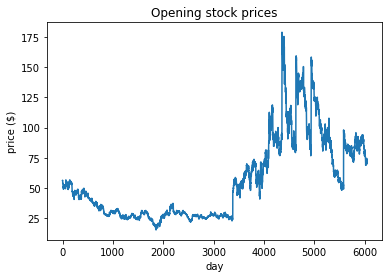

Instructions for updating:
Colocations handled automatically by placer.
Running simulation 1...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $85243.69805100014
Running simulation 2...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $217634.22995700032
Running simulation 3...
progress 0.00%
progress 16.55%


In [ ]:
#Funcion de entrada al modulo
if __name__ == '__main__':
    #Obtiene la lista de precios para MFT entre las fechas indicadas
    prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
    #Representa los precios de la accion
    plot_prices(prices)
    
    #Definimos las acciones de nuestro modelo. Son tres
    actions = ['Buy', 'Sell', 'Hold']
    hist = 3
    
    #Este es el metodo en el que se eligen las acciones al azar
    # policy = RandomDecisionPolicy(actions)
    #En este metodo se eligen las acciones usando una RN. La dimension del vector de entrada para la red neuronal
    #es cinco. Esto significa que sutilizan cinco estados para entrenar la RN en cual es la accion que debe tomarse
    policy = QLearningDecisionPolicy(actions, hist + 2)
    
    budget = 100000.0
    num_stocks = 0
    run_simulations(policy, budget, num_stocks, prices, hist)